## Lab 6: Association Rile Mining with Apriori and FP-Growth
Anna Bottu

MSCS-634: Advanced Big Data and Data Mining

## Step 1: Data Preperation

In [3]:
import os
os.getcwd()

'/Users/annabottu/Documents/Lab6'

In [4]:
#for data loading
import pandas as pd

#loads the product info from the products.csv
products = pd.read_csv("products.csv")

#loads the departments info from the departments.csv
departments = pd.read_csv("departments.csv")

#loads the aisles info from the aisles.csv
aisles = pd.read_csv("aisles.csv")

#loads the orders info from the orders.csv
orders = pd.read_csv("orders.csv")

#loads the order products prior info from the order_products__prior.csv
order_products_prior = pd.read_csv("order_products__prior.csv")

#loads the order products train info from the order_products__train.csv
order_products_train = pd.read_csv("order_products__train.csv")

Loads and merges all the differnt dataset files into one dataframe so it is easier to analyze and is ready for the Apriori adn FP-Growth alogithms

In [5]:
order_products = pd.concat([order_products_prior, order_products_train], ignore_index=True)

In [6]:
merged_df = pd.merge(order_products, products, on="product_id", how="left")

In [7]:
merged_df = pd.merge(merged_df, aisles, on="aisle_id", how="left")
merged_df = pd.merge(merged_df, departments, on="department_id", how="left")

In [8]:
merged_df = pd.merge(merged_df, orders, on="order_id", how="left")

In [9]:
print(merged_df)

          order_id  product_id  add_to_cart_order  reordered  \
0                2       33120                  1          1   
1                2       28985                  2          1   
2                2        9327                  3          0   
3                2       45918                  4          1   
4                2       30035                  5          0   
...            ...         ...                ...        ...   
33819101   3421063       14233                  3          1   
33819102   3421063       35548                  4          1   
33819103   3421070       35951                  1          1   
33819104   3421070       16953                  2          1   
33819105   3421070        4724                  3          1   

                             product_name  aisle_id  department_id  \
0                      Organic Egg Whites        86             16   
1                   Michigan Organic Kale        83              4   
2                    

### Data cleaning

In [10]:
import pandas as pd

#keeps only transaction ID and product name
df_clean = merged_df[['order_id', 'product_name']].dropna()

#remove any duplicates
df_clean = df_clean.drop_duplicates()

#checks for nulls 
print(df_clean.isnull().sum())

df_clean.head()


order_id        0
product_name    0
dtype: int64


,order_id,product_name
0,2,Organic Egg Whites
1,2,Michigan Organic Kale
2,2,Garlic Powder
3,2,Coconut Butter
4,2,Natural Sweetener


In [11]:
df_clean.groupby('order_id')['product_name'].count().head()

order_id
1     8
2     9
3     8
4    13
5    26
Name: product_name, dtype: int64

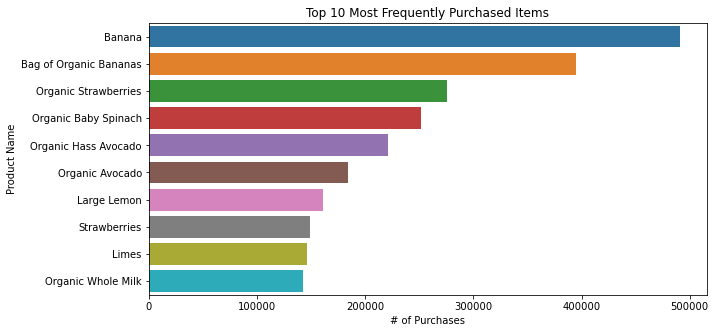

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

#counts the top 10 most frequently bought products and plots them in a bar chart
#count product frequency
item_counts = df_clean['product_name'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=item_counts.values, y=item_counts.index, palette="tab10")
plt.title("Top 10 Most Frequently Purchased Items")
plt.xlabel("# of Purchases")
plt.ylabel("Product Name")
plt.show()

Shows that bananas are the most popular item purchased

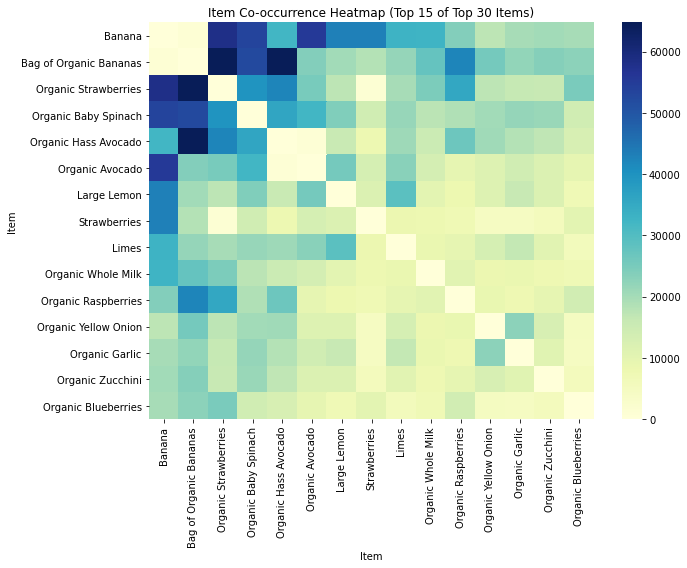

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#limit to the most frequent items to only 30
K = 30
top_items = df_clean['product_name'].value_counts().head(K).index
df_top = df_clean[df_clean['product_name'].isin(top_items)].drop_duplicates()

X = pd.crosstab(df_top['order_id'], df_top['product_name']).astype(bool).astype(int)

C = X.T.dot(X)
np.fill_diagonal(C.values, 0) 

N = 15
plot_items = df_clean['product_name'].value_counts().loc[top_items].head(N).index
C_plot = C.loc[plot_items, plot_items]

# plots a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(C_plot, annot=False, cmap="YlGnBu")
plt.title(f"Item Co-occurrence Heatmap (Top {N} of Top {K} Items)")
plt.xlabel("Item")
plt.ylabel("Item")
plt.tight_layout()
plt.show()


## Step 2: Frequent Itemset Mining Using Apriori

In [14]:
!pip install mlxtend


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
ERROR: Exception:
Traceback (most recent call last):
  File "/Users/annabottu/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 105, in _run_wrapper
    status = _inner_run()
  File "/Users/annabottu/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 96, in _inner_run
    return self.run(options, args)
  File "/Users/annabottu/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/Users/annabottu/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/commands/install.py", line 483, in run
    installed_versions[distribution.canonical_name] = distribution.version
  File "/Users/annabottu/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/metadata/pkg_resources.py", line 192, in version
    return parse_version(self._dist.

In [38]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

#avoid double-counting same item
df_small = df_clean.drop_duplicates(['order_id','product_name'])

#only the top-K most frequent items to control the number of columns to reduce dimensionality 
K = 300  
top_items = df_small['product_name'].value_counts().head(K).index
df_small = df_small[df_small['product_name'].isin(top_items)]

#limits the number of transactions
MAX_ORDERS = 200_000 
keep_orders = df_small['order_id'].drop_duplicates().head(MAX_ORDERS)
df_small = df_small[df_small['order_id'].isin(keep_orders)]

transactions = df_small.groupby('order_id')['product_name'].apply(list).tolist()

#used to save memory
te = TransactionEncoder()
sparse_ary = te.fit(transactions).transform(transactions, sparse=True)

df_encoded = pd.DataFrame.sparse.from_spmatrix(sparse_ary, columns=te.columns_)
df_encoded = df_encoded.astype('bool')

df_encoded.info()  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 300 entries, 100% Raw Coconut Water to YoKids Squeezers Organic Low-Fat Yogurt, Strawberry
dtypes: Sparse[bool, False](300)
memory usage: 4.1 MB


From the data above you can see that there are 200,00 orders which we set by max_orders, and there are 300 products for columns.

In [22]:
from mlxtend.frequent_patterns import apriori

# Run Apriori
top_itemsets = frequent_itemsets.head(top_n).copy()   # <-- important
top_itemsets.loc[:, 'itemset_str'] = top_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))

print(frequent_itemsets.head(10))


      support                  itemsets
7    0.179140                  (Banana)
6    0.142275  (Bag of Organic Bananas)
93   0.098960    (Organic Strawberries)
45   0.090885    (Organic Baby Spinach)
70   0.079805    (Organic Hass Avocado)
41   0.065875         (Organic Avocado)
35   0.057675             (Large Lemon)
121  0.053995            (Strawberries)
37   0.052790                   (Limes)
96   0.051400      (Organic Whole Milk)


Plots the Apriori to show the insights

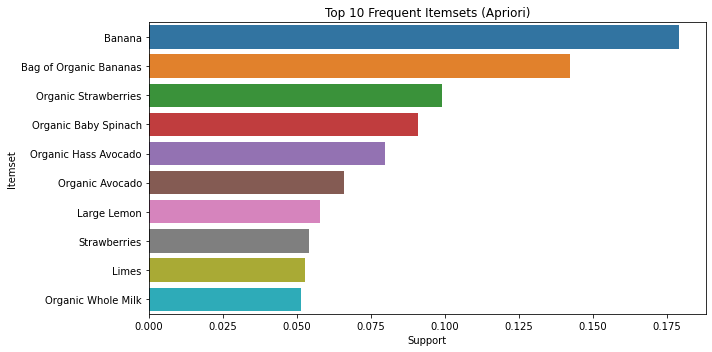

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message=".*should_run_async.*", category=DeprecationWarning)

top_n = 10
top_itemsets = frequent_itemsets.head(top_n).reset_index(drop=True).copy()
top_itemsets.loc[:, 'itemset_str'] = top_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))
plot_df = top_itemsets


plt.figure(figsize=(10,5))
sns.barplot(x='support', y='itemset_str', data=plot_df)
plt.title(f"Top {top_n} Frequent Itemsets (Apriori)")
plt.xlabel("Support"); plt.ylabel("Itemset")
plt.tight_layout()
plt.show()


From the graoh above it shows the top 10 most popular products that were bought with bananas being the most popular. 

## Step 3: Frequent Itemset Mining Using FP-Growth

In [25]:
from mlxtend.frequent_patterns import fpgrowth

#runs FP-Growth
frequent_itemsets_fp = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)

#sorts by support
frequent_itemsets_fp = frequent_itemsets_fp.sort_values(by='support', ascending=False)

print(frequent_itemsets_fp.head(10))


     support                  itemsets
15  0.179140                  (Banana)
6   0.142275  (Bag of Organic Bananas)
16  0.098960    (Organic Strawberries)
2   0.090885    (Organic Baby Spinach)
7   0.079805    (Organic Hass Avocado)
17  0.065875         (Organic Avocado)
42  0.057675             (Large Lemon)
54  0.053995            (Strawberries)
69  0.052790                   (Limes)
24  0.051400      (Organic Whole Milk)


In [26]:
import time
from mlxtend.frequent_patterns import apriori

#prints the apriori run times
start_ap = time.time()
apriori(df_encoded, min_support=0.01, use_colnames=True)
end_ap = time.time()

#pritns the FP-Growth run time
start_fp = time.time()
fpgrowth(df_encoded, min_support=0.01, use_colnames=True)
end_fp = time.time()

print(f"Apriori runtime: {end_ap - start_ap:.2f} seconds")
print(f"FP-Growth runtime: {end_fp - start_fp:.2f} seconds")


Apriori runtime: 24.49 seconds
FP-Growth runtime: 18.24 seconds


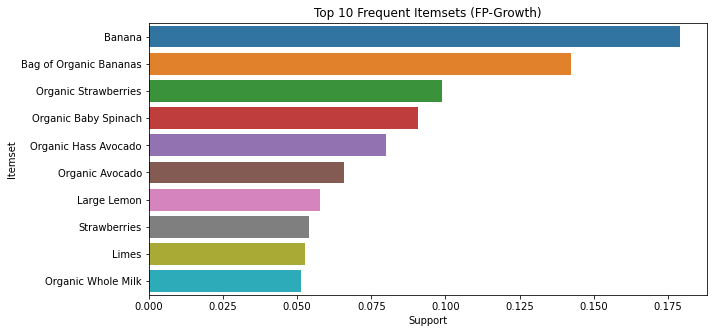

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

top_n = 10
top_itemsets_fp = frequent_itemsets_fp.head(top_n).copy()
top_itemsets_fp['itemset_str'] = top_itemsets_fp['itemsets'].apply(lambda x: ', '.join(list(x)))

plt.figure(figsize=(10,5))
sns.barplot(x='support', y='itemset_str', data=top_itemsets_fp, palette="tab10")
plt.title(f"Top {top_n} Frequent Itemsets (FP-Growth)")
plt.xlabel("Support")
plt.ylabel("Itemset")
plt.show()


## Step 4: Generating and Analyzing Association Rules

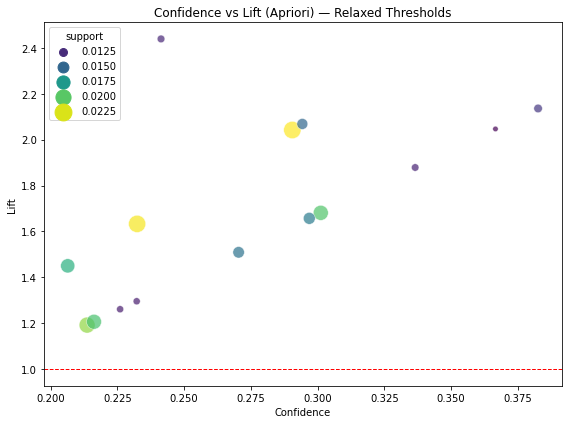

In [40]:
from mlxtend.frequent_patterns import association_rules

#generate rules with lower thresholds and allow bigger itemsets
rules_ap = association_rules(
    frequent_itemsets, 
    metric="confidence", 
    min_threshold=0.2 
)

rules_ap = rules_ap.dropna(subset=['lift'])

#keeps the positive associations
rules_ap = rules_ap[rules_ap['lift'] > 1.0]


strong_rules_ap = rules_ap[
    (rules_ap['confidence'] >= 0.2) &  
    (rules_ap['lift'] >= 1.05)          
]


if strong_rules_ap.shape[0] > 200:
    strong_rules_ap = strong_rules_ap.sort_values(
        by='support', ascending=False
    ).head(200)

#plots the scatter plot for Confidence vs Lift
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=strong_rules_ap, 
    x='confidence', 
    y='lift',
    size='support', 
    hue='support',
    sizes=(30, 300), 
    alpha=0.7, 
    palette='viridis'
)
plt.title("Confidence vs Lift (Apriori) — Relaxed Thresholds")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.axhline(1, color='red', linestyle='--', linewidth=1)  # lift baseline
plt.tight_layout()
plt.show()



the graph above we can see the relationship between confidence and lift for the association rules that we got. We can see that although there are many product combinations, there are only a few that bought together with good predictive power

## Step 5: Comparitive Analysis

After comparing the results between Apriori and FP-Growth, the cells above show that the runtime for Apriori was 24.49 seconds and the runtime for FP-Growth was 18.24 seconds, making FP-Growth faster. FP-Growth algorithm was faster for my dataset was because the instacart dataset has many items and becuase of that the Apriori algorithmn slows down as the number of products increase and FP-Growth is better for datasets with many products. Apriori requires the dataset to be pased through mutliple times, where that is not necessay for FP-Growth. Some of the challenges I faced was with memory overload issues, where the kernal would crash because of how much memory it was using, but I was able to resolve it mimiting the transaction to only 200K orders. I also had a problem with the heatmap, due to the huge number of item pairs. But I was able to resolve it by using pd.crosstab() and .T.dot() by filtering only the most popular products. 